### An introduction to
# Style Transfer
### By using Deep Learning techniques
<a rel="license" href="http://creativecommons.org/licenses/by-nd/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nd/4.0/88x31.png" /></a><br />All the images, unless otherwise indicated explicitly, is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nd/4.0/">Creative Commons Attribution-NoDerivatives 4.0 International License</a>.

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

<small><i>June 2016 - This notebook was created by [Axel Brando](http://axelbrando.github.io/) for the [Deep Learning from Scratch Course](https://github.com/DataScienceUB/DeepLearningfromScratch).</i></small>

In [ ]:
#In order to solve the different version of the Docker, run this cell.
#numpy 1.8.2 -> numpy-1.11.0
!pip install numpy --upgrade

The following source is an adaptation for our problem of the Anish Athalye's source code found in his github repository neural-style (https://github.com/anishathalye/neural-style).

Using the ideas from the papers:

[1] Gatys, L. A., Ecker, A. S., & Bethge, M. (2015). A neural algorithm of artistic style. arXiv preprint arXiv:1508.06576.

[2] Ulyanov, D., Lebedev, V., Vedaldi, A., & Lempitsky, V. (2016). Texture Networks: Feed-forward Synthesis of Textures and Stylized Images. arXiv preprint arXiv:1603.03417.

[3] Johnson, J., Alahi, A., & Fei-Fei, L. (2016). Perceptual Losses for Real-Time Style Transfer and Super-Resolution. arXiv preprint arXiv:1603.08155.

and other related:

[4] Gatys, L., Ecker, A. S., & Bethge, M. (2015). Texture synthesis using convolutional neural networks. In Advances in Neural Information Processing Systems (pp. 262-270).

[5] Mahendran, A., & Vedaldi, A. (2015, June). Understanding deep image representations by inverting them. In Computer Vision and Pattern Recognition (CVPR), 2015 IEEE Conference on (pp. 5188-5196). IEEE.

[6] Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.



<img src="styleTransferPart/StylesUB.png" alt="Pybonacci" style="width: 600px;"/> 

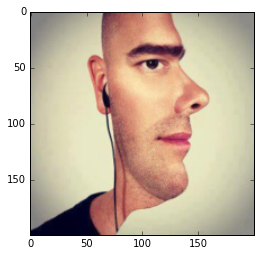

In [2]:
import scipy.misc
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def imread(path):
    return scipy.misc.imread(path).astype(np.float)

def imsave(path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    scipy.misc.imsave(path, img)

CONTENT_IMAGE = 'examples/fotos-de-perfil.jpg'
content_image = imread(CONTENT_IMAGE)

width = 200
new_shape = (int(math.floor(float(content_image.shape[0]) / 
                            content_image.shape[1] * width)), width)
content_image = scipy.misc.imresize(content_image, new_shape)
plt.imshow(content_image)

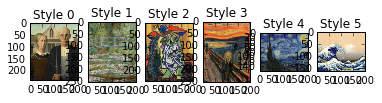

In [5]:
styles_paths = ['AmericanGothic.jpg',
                'Monet-bridge-red.jpg',
                'Picaso-The-Wedding-Woman.jpg',
                'Munch-Skrik.jpg',
                'starry-night.jpg',
                'the-great-wave-off-kanagawa.jpg']
style_scale = 1.0
style_images = []

for style in styles_paths:
    image = imread('styleTransferPart/'+style)
    style_images += [scipy.misc.imresize(image, style_scale * 
                                         content_image.shape[1] / 
                                         image.shape[1])]
l = len(style_images)
style_blend_weights = [1.0/l for _ in style_images]

fig = plt.figure()
for i in xrange(l):
    a=fig.add_subplot(1,l,i+1)
    plt.imshow(style_images[i])
    a.set_title('Style '+str(i))

In [4]:
import tensorflow as tf

Gatys *et al.* [1] recently demonstrated that pretrained feed-forward convolutional neural network could be used to solve an **optimization problem** in order to transfer the style of an image to another one. The aim of that optimization is to **generate a new image that matches** the **visual style** of a first image, captured by using some low-level statistics, and the **visual content** of a second image, captured by using higher-level statistics. Thus, this article introduces a new idea in order to separate the style from the content of an image and to recast the content in the style of any other image.

## Image generation using neural networks
Ulyanov *et al.* [2], in their article, summarized the reasons why the process works and where their possible inspiration comes from:

The first important step is to understand the process of generating an image $x$ as the problem of drawing a sample from a certain distribution $p(x)$. In [texture synthesis](https://en.wikipedia.org/wiki/Texture_synthesis), the distribution is induced by an example of a texture instance $x_0$ such that we can write $x$ ~ $p(x \mid x_0)$. In style transfer, the distribution is induced by an image $x_0$, which is representative of the visual style (*e.g.* an impressionist painting) and a second image $x_1$, which is representative of the visual content (*e.g.* a cat), such that $x$ ~ $p(x \mid x_0, x_1)$.

Mahendran *et al.* [5] and Gatys *et al.* [4] reduced this problem to the one of finding a *pre-image* of a certain image statistics and posed the latter as an optimization problem.

<img src="styleTransferPart/Content-Style.png" alt="Pybonacci" style="width: 600px;"/> 
<font size="1">Image extracted from the paper of Gatys et al. [1]</font>

## Content Reconstruction
The second step is to know which architecture is selected and how the features that will allow the process of content match are computed.

All the results obtained by Gatys *et al.* [1] were generated by comparing the image statistics extracted from fixed descriptors of the 19-layers VGG-Network pre-trained for image classification on the ImageNet ILSVRC 2012 data (presented by Simonyan *et al.* [6]). Currently, the *pre-trained* model is publicly available in most of important Frameworks. 

<img src="styleTransferPart/VGG19.jpg" alt="Pybonacci" style="width: 350px;"/> 
<font size="1">Image extracted from [PyData London CNN Lightning Talk ](http://www.slideshare.net/ejlbell/pydata-london-cnn-lightning-talk)</font>

In particular, they used the feature space provided by the $16$ convolutional and $5$ pooling layers of the network and they do not use any of the fully connected layers.


Next, there is a definition of the VGG class:

In [5]:
import os
import scipy.io

VGG_PATH = '../imagenet-vgg-verydeep-19.mat'
if not os.path.isfile(VGG_PATH):
        parser.error("Network %s does not exist. (Did you forget to download it?)" % VGG_PATH)

class vgg:
    @staticmethod
    def net(data_path, input_image):
        layers = (
            'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

            'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

            'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
            'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

            'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
            'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

            'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
            'relu5_3', 'conv5_4', 'relu5_4'
        )

        data = scipy.io.loadmat(data_path)
        mean = data['normalization'][0][0][0]
        mean_pixel = np.mean(mean, axis=(0, 1))
        weights = data['layers'][0]

        net = {}
        current = input_image
        for i, name in enumerate(layers):
            kind = name[:4]
            if kind == 'conv':
                kernels, bias = weights[i][0][0][0][0]
                # matconvnet: weights are [width, height, in_channels, out_channels]
                # tensorflow: weights are [height, width, in_channels, out_channels]
                kernels = np.transpose(kernels, (1, 0, 2, 3))
                bias = bias.reshape(-1)
                current = vgg._conv_layer(current, kernels, bias)
            elif kind == 'relu':
                current = tf.nn.relu(current)
            elif kind == 'pool':
                current = vgg._pool_layer(current)
            net[name] = current

        assert len(net) == len(layers)
        return net, mean_pixel

    @staticmethod
    def _conv_layer(input, weights, bias):
        conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1),
                padding='SAME')
        return tf.nn.bias_add(conv, bias)

    @staticmethod
    def _pool_layer(input):
        return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
                padding='SAME')

    @staticmethod
    def preprocess(image, mean_pixel):
        return image - mean_pixel

    @staticmethod
    def unprocess(image, mean_pixel):
        tmp =  image + mean_pixel
        return tmp.astype(np.uint8)

A convolutional layer $l$ with $N_l$ different filters has $N_l$ feature maps, and each of them has the size $M_l$ when vectorized. Then, according to Gatys *et al.* [1], if $F^l \in \mathbb{R}^{N_{l}\times M_{l}}$ is the feature map matrix in the layer $l$, and thus, $F_{i,j}^l$ the activation of the $i^{th}$ filter at position $j$ in the layer $l$, they propose to perfom a gradient descent process starting from a noise image to find another image that matches the feature responses of the original image.

In order to do this, let $\overrightarrow{c}$ and $\overrightarrow{x}$ be the original and the image generated and $C^l$ and $F^l$ their respective feature representation in layer $l$. The loss function to have minimised will be the following one:

$$\mathcal{L}_{content}(\overrightarrow{c},\overrightarrow{x},l)=\frac{1}{2}\underset{i,j}{\sum}(F_{i,j}^{l}-C_{i,j}^{l})^{2}$$

Therefore, the gradient of this loss regarding the activation in layers $l$ will be:

$$\frac{\partial\mathcal{L}_{content}}{\partial F_{i,j}^{l}}=\begin{cases}
(F^{l}-C^{l})_{i,j} & \mbox{if }F_{i,j}^{l}>0\\
0 & \mbox{if }F_{i,j}^{l}<0
\end{cases}$$

Now, there is a definition of the fixed computation of the features in the CONTENT_LAYER selected layer in the VGG-Network of our *content_image* image:

In [6]:
CONTENT_LAYER = 'relu4_2'
content_features = {}

# compute content features in feedforward mode
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    image = tf.placeholder('float', shape=(1,)+content_image.shape)
    net, mean_pixel = vgg.net(VGG_PATH, image)
    content_pre = np.array([vgg.preprocess(content_image, mean_pixel)])
    content_features[CONTENT_LAYER] = net[CONTENT_LAYER].eval(
            feed_dict={image: content_pre})

After that, it will only be necessary to implement the loss function described above. This will be done in the *backprogation* part.

## Style Reconstruction

In each selected convolutional layer, Gatys *et al.* [1] built a style representation that computes the correlation between the different filter responses, where the expectation was taken over the spatial extend of the input image. To achieve this effect, Gatys *et al* [1,4] proposed to use the feature correlation that produces the **Gram matrix** operator $G^l \in \mathbb{R}^{N_{l}\times N_{l}}$, where the shape of the feature map of the layer $l$ is ($N_l \times H_l \times W_l = N_l \times M_l$) and $G^l_{i,j}$ is the inner product between the vectorized feature map $i$ and $j$ in layer $l$:

$$G^l_{i,j} = \underset{k}{\sum}F_{i,k}^{l}F_{j,k}^{l}$$

As in the *content reconstruction* case, to generate a texture that matches with the style of a given image, they used gradient descent from a random image to find another image that matches with the style representation of the original image.

In order to do this, let $\overrightarrow{s}$ and $\overrightarrow{x}$ be the original image and the image that is generated, and let $S^l$ and $G^l$ their respective style representation in layer $l$, the loss function to be minimised will be the following one:

$$\mathcal{L}_{style}(\overrightarrow{s},\overrightarrow{x},l)=\frac{1}{4 N_l^2 M_l^2}\underset{i,j}{\sum}(G_{i,j}^{l}-S_{i,j}^{l})^{2}$$

The derivative of this loss concerning the activation in layer $l$ can be computed analytically:

$$\frac{\partial\mathcal{L}_{style}}{\partial F_{i,j}^{l}}=\begin{cases}
\frac{1}{N_l^2 M_l^2}((F^{l})^T(G^{l}-C^{l})_{j,i} & \mbox{if }F_{i,j}^{l}>0\\
0 & \mbox{if }F_{i,j}^{l}<0
\end{cases}$$

In the case we would like to converge the loss function at different levels of style representation (by using different layers), the way proposed in Gatys *et al.* [1] is to weigh the different style losses computed for each layer. In our case, we will give the same weighted normalized value to all style loss functions.

Now, there is a definition of the fixed computation of the features in the STYLE_LAYER selected layers in the VGG-Network of our *style_images* images:

In [7]:
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

style_shapes = [(1,) + style.shape for style in style_images]
style_features = [{} for _ in style_images]

# compute style features in feedforward mode
for i in range(len(style_images)):
    g = tf.Graph()
    with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
        image = tf.placeholder('float', shape=style_shapes[i])
        net, _ = vgg.net(VGG_PATH, image)
        style_pre = np.array([vgg.preprocess(style_images[i], mean_pixel)])
        for layer in STYLE_LAYERS:
            features = net[layer].eval(feed_dict={image: style_pre})
            features = np.reshape(features, (-1, features.shape[3]))
            gram = np.matmul(features.T, features) / features.size
            style_features[i][layer] = gram

## Make Stylized image using back-propagation

The gradient of the content and the style loss functions regarding the activations in the 'lower layer' of the network (the input image) can be readily computed by using standard error back-propagation.

However, before starting with this process, we need to define an initial image to start the aproximation from the content and the style perspectives.

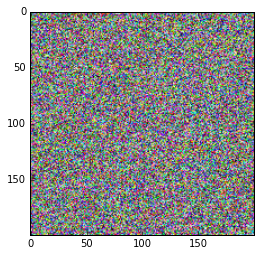

In [8]:
initial = np.random.normal(size=(1,)+content_image.shape, 
                         scale=np.std(content_image) * 0.1)
initial = initial.astype('float32')
plt.imshow(initial[0,...])

#QUESTION: What will happen if we assign initial image as image content?
#initial = np.expand_dims(content_image, axis=0)
#initial = initial.astype('float32')
#plt.imshow(initial[0,...])

In [ ]:
from tqdm import tqdm
from operator import mul
from IPython import display

def _tensor_size(tensor):
    return reduce(mul, (d.value for d in tensor.get_shape()), 1)

ITERATIONS = 1000
learning_rate = 1e1
TV_WEIGHT = 1e2
STYLE_WEIGHT = 1e2
CONTENT_WEIGHT = 5e0
CHECKPOINT = 100
PRINT_LOSS = 100
PRINT_VISUAL = 100

with tf.Graph().as_default():
    #initial = tf.random_normal((1,) + content_image.shape) * 0.256
    image = tf.Variable(initial)
    net, _ = vgg.net(VGG_PATH, image)

    # content loss
    content_loss = CONTENT_WEIGHT * (2 * tf.nn.l2_loss(
            net[CONTENT_LAYER] - content_features[CONTENT_LAYER]) /
            content_features[CONTENT_LAYER].size)
    # style loss
    style_loss = 0
    for i in range(len(style_images)):
        style_losses = []
        for style_layer in STYLE_LAYERS:
            layer = net[style_layer]
            _, height, width, number = map(lambda i: i.value, layer.get_shape())
            size = height * width * number
            feats = tf.reshape(layer, (-1, number))
            gram = tf.matmul(tf.transpose(feats), feats) / size
            style_gram = style_features[i][style_layer]
            style_losses.append(2 * tf.nn.l2_loss(gram - style_gram) / style_gram.size)
        style_loss += STYLE_WEIGHT * style_blend_weights[i] * reduce(tf.add, style_losses)
    # total variation denoising
    tv_y_size = _tensor_size(image[:,1:,:,:])
    tv_x_size = _tensor_size(image[:,:,1:,:])
    tv_loss = TV_WEIGHT * 2 * (
            (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:content_image.shape[0]-1,:,:]) /
                tv_y_size) +
            (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:content_image.shape[1]-1,:]) /
                tv_x_size))
    # overall loss
    loss = content_loss + style_loss + tv_loss

    # optimizer setup
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    # optimization
    best_loss = float('inf')
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        for i in tqdm(range(ITERATIONS)):

            if i % PRINT_VISUAL == 0:
                plt.imshow(vgg.unprocess(image.eval().reshape(content_image.shape), 
                              mean_pixel))
                display.clear_output(wait=False)
                display.display(plt.gcf())
            if i % PRINT_LOSS == 0:
                print '  content loss: %g\n' % content_loss.eval()
                print '    style loss: %g\n' % style_loss.eval()
                print '       tv loss: %g\n' % tv_loss.eval()
                print '    total loss: %g\n' % loss.eval()

            train_step.run()

            if (i % CHECKPOINT == 0):
                this_loss = loss.eval()
                if this_loss < best_loss:
                    best_loss = this_loss
                    best = image.eval()

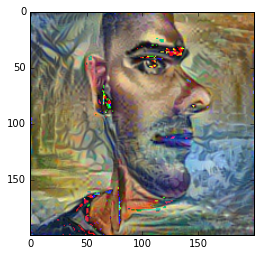

100%|██████████| 1000/1000 [08:55<00:00,  2.02it/s]


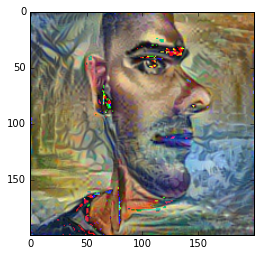

In [9]:
#Result of multi-style (all styles together) using a Tesla K40c GPU.

In [10]:
from scipy import misc
misc.imsave('final-multistyle.jpg',best[0,...]-mean_pixel)

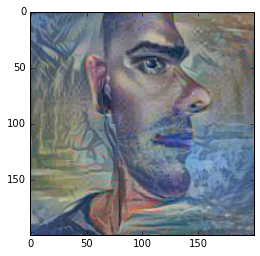

In [11]:
plt.imshow(misc.imread('final-multistyle.jpg'))

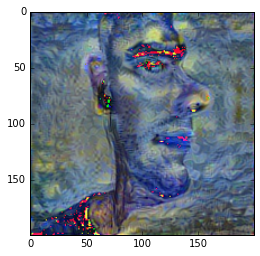

100%|██████████| 1000/1000 [04:02<00:00,  4.28it/s]


In [10]:
#Result of one style using a Tesla K40c GPU.

In [12]:
from scipy import misc
misc.imsave('final.jpg',best[0,...]-mean_pixel)

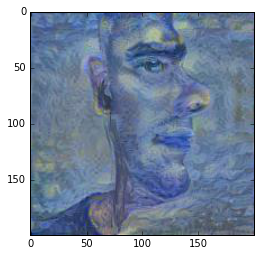

In [14]:
plt.imshow(misc.imread('final.jpg'))

Below we will show an interactive example of back-propagation process:

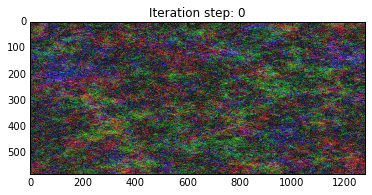

In [3]:
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact
%matplotlib inline
def view_image(i=0):
    plt.imshow(scipy.misc.imread("styleTransferPart/ExampleST/proces_iter-"+str(i)+".jpg"))
    plt.title('Iteration step: %s' % i)
    plt.show()
interact(view_image, i=(0,700,50))

This method require a slow and memory-consuming optimization process. However, recently, some researchers propose another alternatives approaches that moves the computational burden to a learning stage (Ulyanov *et al.* [2] and Johnson *et al.* [3] for more details).